# Alexnet on RSICB dataset

Mount google drive to download the dataset and unzip the data file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/GroupO_DataSet.zip'
extract_dir = 'GroupO_DataSet'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        zip_ref.extract(file, extract_dir)

print("Extraction complete. Check the folder:", extract_dir)


Extraction complete. Check the folder: GroupO_DataSet


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/GroupO_DataSet/RSI-CB/', transform=data_transforms)

In [ ]:
train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

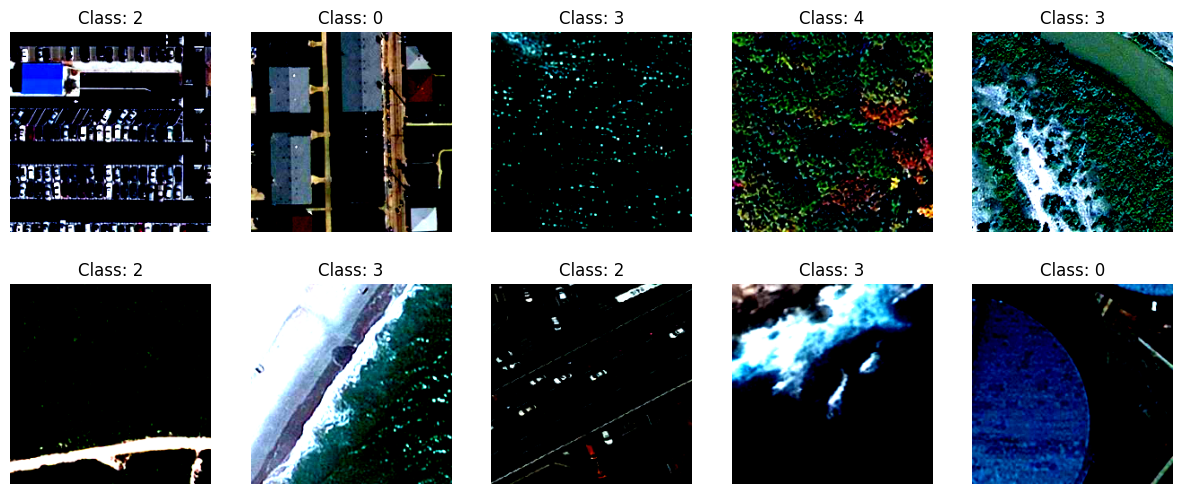

In [ ]:
# Generate a random sample of 10 images from the test dataset
sample_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
sample_iter = iter(sample_loader)
sample_images, sample_labels = next(sample_iter)

# Display the sample images
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Transpose the tensor to (H, W, C) for display
    plt.title(f"Class: {sample_labels[i]}")
    plt.axis('off')
plt.show()


In [ ]:
batch_size = 64
learning_rate = 0.001
num_epochs = 40

# Print the configuration
print(f"Training with batch size: {batch_size}, learning rate: {learning_rate}, and epochs: {num_epochs}")


Training with batch size: 64, learning rate: 0.001, and epochs: 40


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = models.alexnet(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 5)
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
loss_during_epoch = []
accuracy_during_epoch = []


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output, dim=1)

        self.model.zero_grad()
        output[:, target_class].backward(retain_graph=True)

        gradients = self.gradients[0].cpu().data.numpy()
        activations = self.activations[0].cpu().data.numpy()

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(cam, original_image, alpha=0.5):
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(original_image / 255)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


Epoch 1, Loss: 0.7354303349406173, Accuracy: 72.17%, Validation Loss: 0.655722214417024, Validation Accuracy: 75.24%, Running time: 66.92619609832764


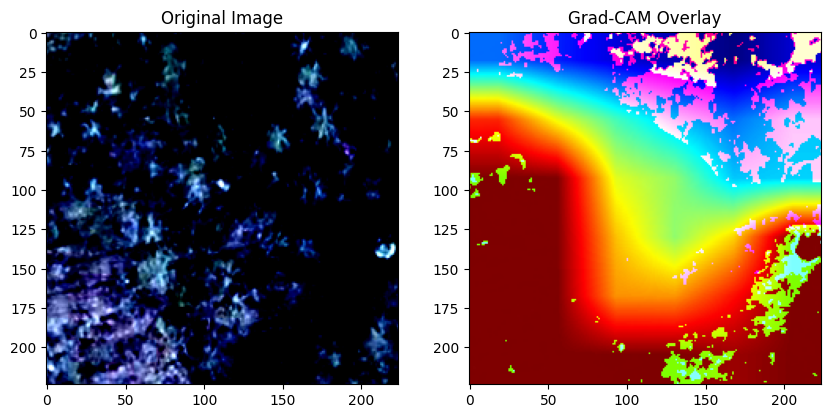

Epoch 2, Loss: 0.5831788699606281, Accuracy: 77.67%, Validation Loss: 0.5875162888656963, Validation Accuracy: 78.07%, Running time: 66.81091952323914


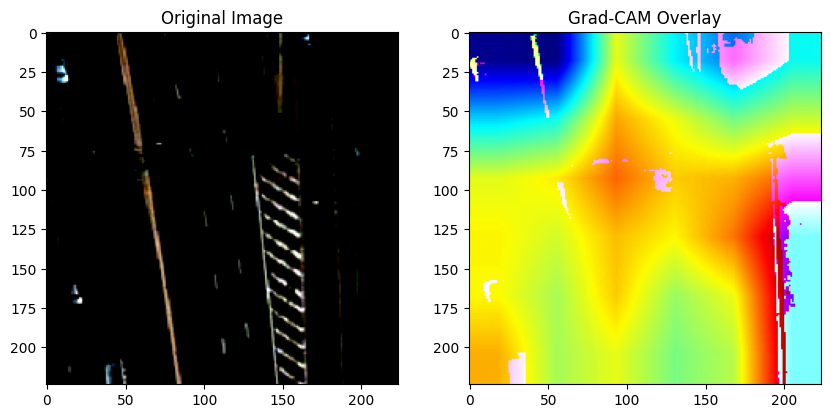

Epoch 3, Loss: 0.5195044428755194, Accuracy: 80.80%, Validation Loss: 0.4694950232903163, Validation Accuracy: 83.32%, Running time: 66.02932214736938


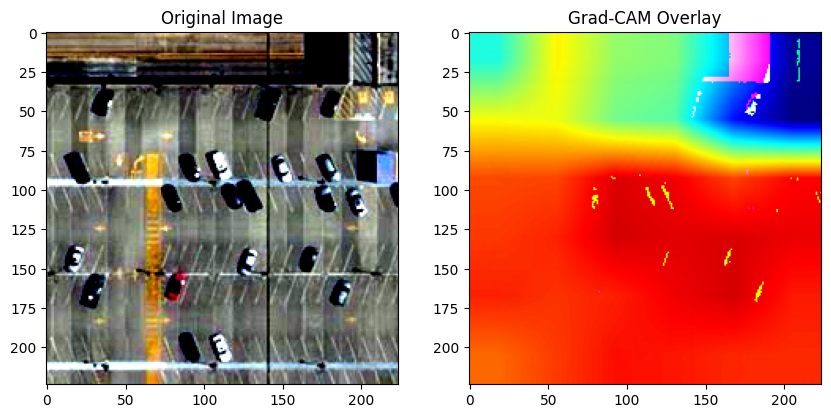

Epoch 4, Loss: 0.4434741712880857, Accuracy: 84.28%, Validation Loss: 0.3308533658132409, Validation Accuracy: 88.69%, Running time: 65.75363087654114


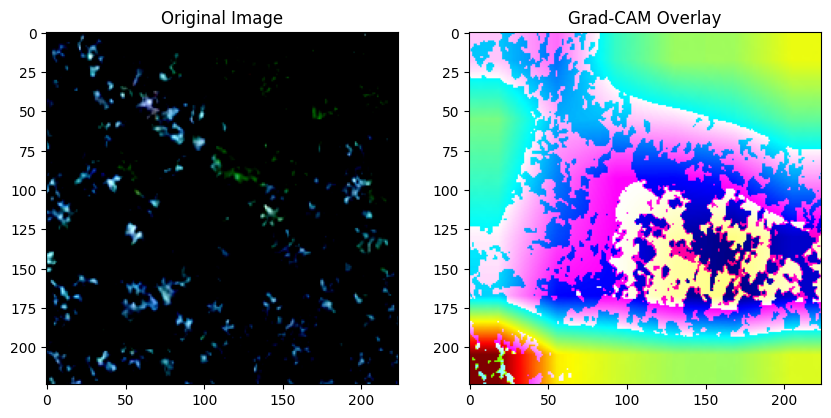

Epoch 5, Loss: 0.36227812491421835, Accuracy: 86.96%, Validation Loss: 0.5120681763598414, Validation Accuracy: 81.66%, Running time: 65.63767123222351


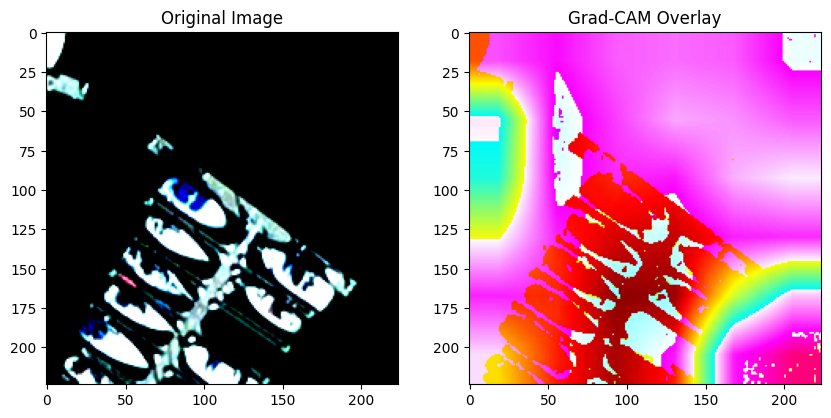

Epoch 6, Loss: 0.3411201997236772, Accuracy: 87.71%, Validation Loss: 0.29824248633601447, Validation Accuracy: 89.19%, Running time: 66.82099509239197


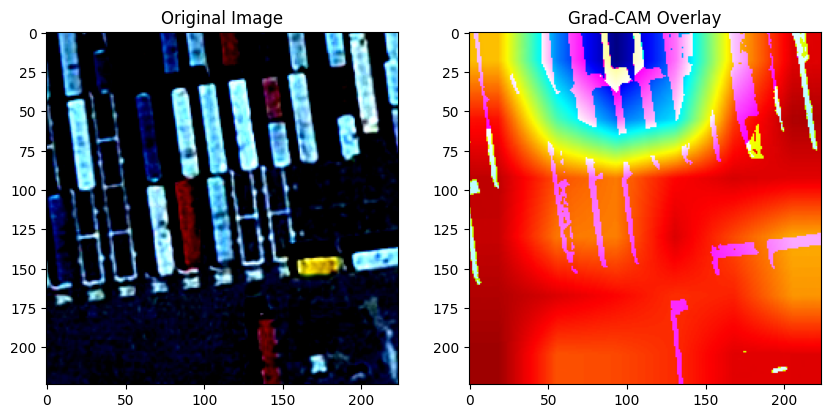

Epoch 7, Loss: 0.33413553650761063, Accuracy: 88.35%, Validation Loss: 0.29045319534612424, Validation Accuracy: 89.57%, Running time: 67.10849523544312


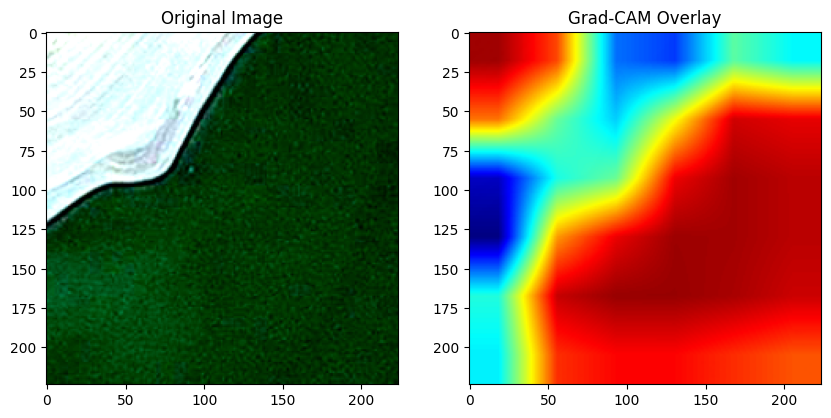

Epoch 8, Loss: 0.2739793812428718, Accuracy: 90.35%, Validation Loss: 0.30628363076936116, Validation Accuracy: 89.83%, Running time: 67.07617926597595


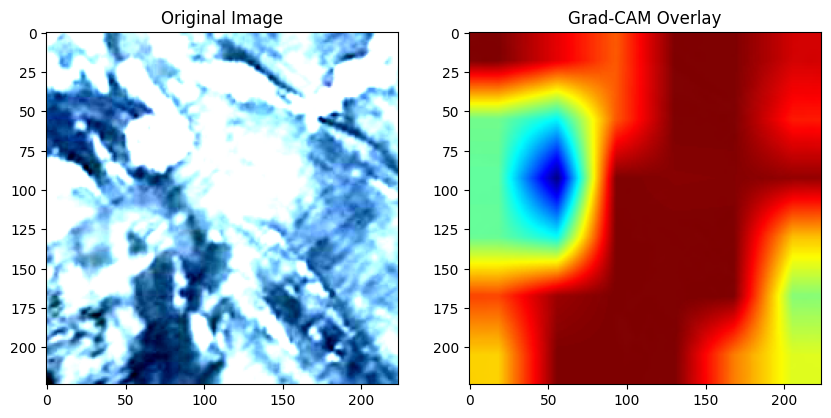

Epoch 9, Loss: 0.26348045240942536, Accuracy: 90.90%, Validation Loss: 0.270017308832118, Validation Accuracy: 91.64%, Running time: 66.8261661529541


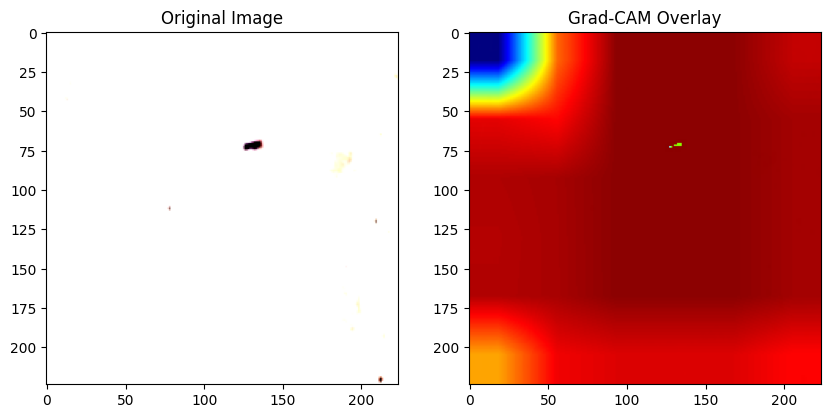

Epoch 10, Loss: 0.2262294784639821, Accuracy: 91.99%, Validation Loss: 0.23185909776525063, Validation Accuracy: 92.06%, Running time: 67.02660822868347


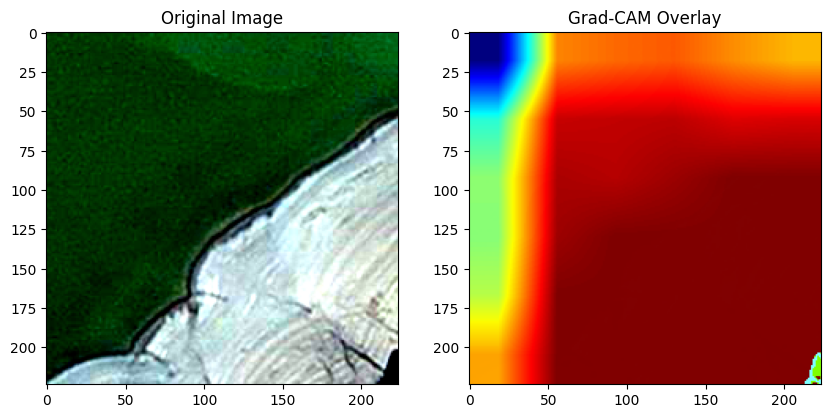

Epoch 11, Loss: 0.23089698294088953, Accuracy: 92.21%, Validation Loss: 0.2603025131604888, Validation Accuracy: 90.40%, Running time: 67.3470549583435


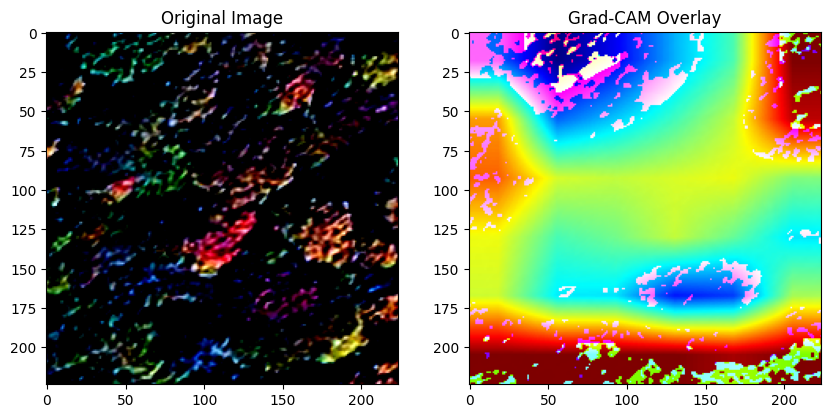

Epoch 12, Loss: 0.21991717870230282, Accuracy: 92.12%, Validation Loss: 0.20894869563705992, Validation Accuracy: 92.21%, Running time: 66.81305694580078


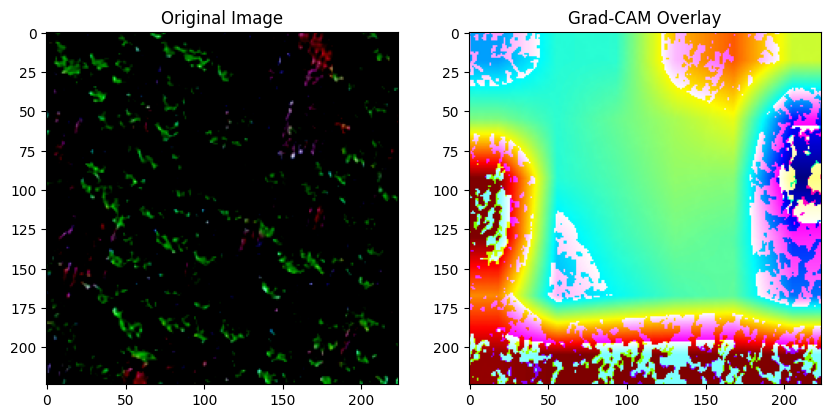

Epoch 13, Loss: 0.17795303599400955, Accuracy: 93.71%, Validation Loss: 0.24579988634496025, Validation Accuracy: 92.92%, Running time: 66.64060735702515


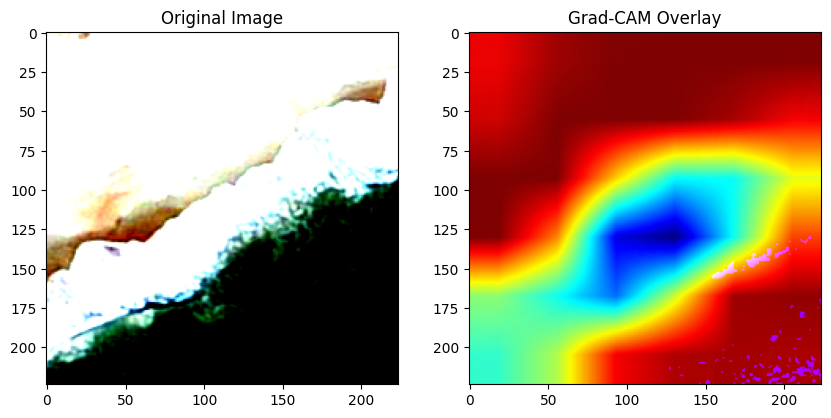

Epoch 14, Loss: 0.23357367909057833, Accuracy: 91.82%, Validation Loss: 0.2688638758704518, Validation Accuracy: 91.02%, Running time: 66.0088484287262


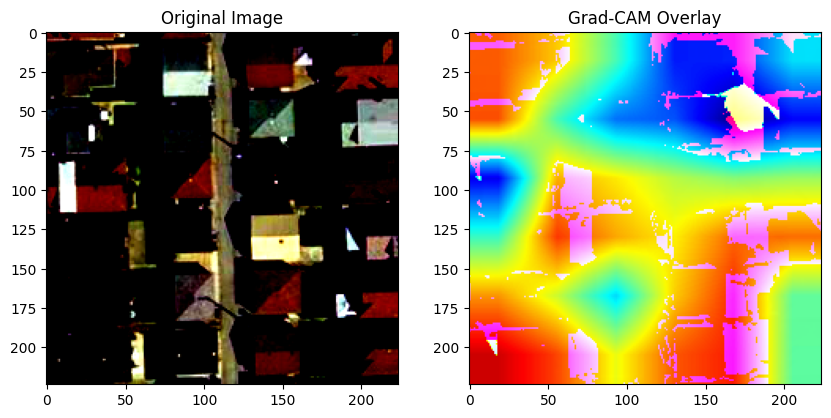

Epoch 15, Loss: 0.17863369539573595, Accuracy: 93.73%, Validation Loss: 0.23504664556998195, Validation Accuracy: 93.42%, Running time: 66.06626653671265


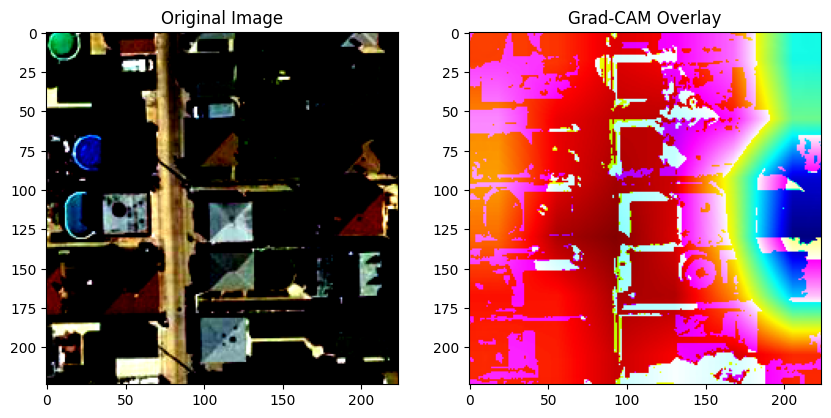

Epoch 16, Loss: 0.18732252118713927, Accuracy: 93.97%, Validation Loss: 0.2562992624148275, Validation Accuracy: 91.64%, Running time: 66.07771706581116


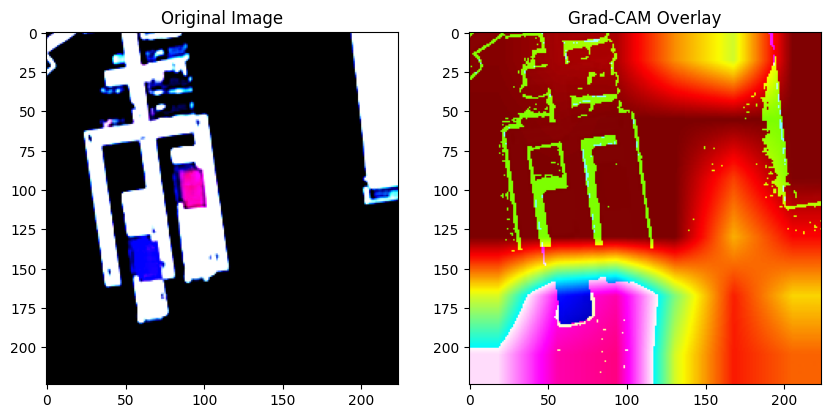

Epoch 17, Loss: 0.15622340711599692, Accuracy: 94.61%, Validation Loss: 0.22908802866709954, Validation Accuracy: 93.54%, Running time: 65.89730262756348


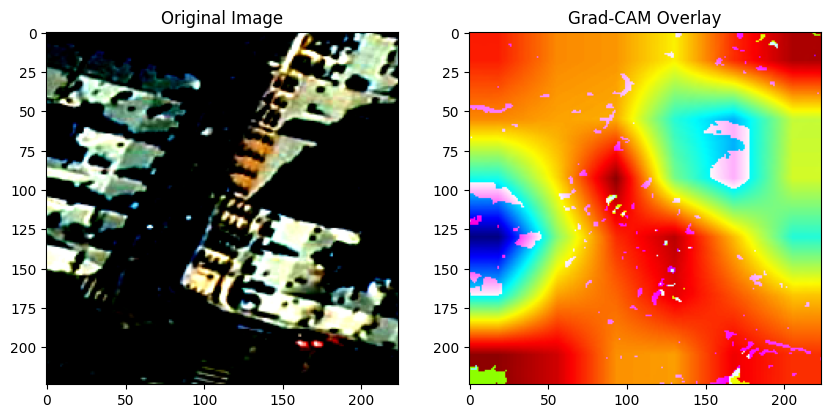

Early stopping!
Training stopped due to early stopping.


In [ ]:
patience = 5
best_valid_loss = float('inf')
epochs_no_improve = 0
early_stopping = False

train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    model.eval()
    valid_loss = 0.0
    valid_correct_predictions = 0
    valid_total_predictions = 0

    with torch.no_grad():
        for valid_inputs, valid_labels in valid_loader:
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            valid_outputs = model(valid_inputs)
            valid_loss += criterion(valid_outputs, valid_labels).item()

            _, valid_predicted = torch.max(valid_outputs, 1)
            valid_correct_predictions += (valid_predicted == valid_labels).sum().item()
            valid_total_predictions += valid_labels.size(0)

    end_time = time.time()
    elapsed_time = end_time - start_time

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = valid_correct_predictions / valid_total_predictions

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_loss}, Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy * 100:.2f}%, "
          f"Running time: {elapsed_time}")

    sample_inputs, sample_labels = next(iter(valid_loader))
    sample_inputs = sample_inputs.to(device)
    original_image = sample_inputs[0].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format

    cam = gradcam.generate_cam(sample_inputs[0].unsqueeze(0))  # Generate Grad-CAM
    overlay_image = visualize_gradcam(cam, original_image)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay_image)
    plt.show()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping!")
            early_stopping = True
            break

if early_stopping:
    print("Training stopped due to early stopping.")
else:
    print("Training completed all epochs.")
